**STEP 1: Build the Segmentation Model Backbone (MFPResNetUNet)**

Importing necessary libraries for data loading, transformation, and augmentation

In [1]:
import os

# Create a folder to store output visualizations and predictions
os.makedirs("outputs/images", exist_ok=True)
os.makedirs("outputs/masks", exist_ok=True)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import torchvision.datasets as dset
import random
import numpy as np
from PIL import Image
import os
os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

import albumentations as A


In [3]:
!pip install albumentations pycocotools --quiet


We define the paths to the LVIS and Berkeley Segmentation Dataset (BSDS500) directories

In [4]:
LVIS_PATH = "/kaggle/input/lvis-v1"
BERKELEY_PATH = "/kaggle/input/berkeley-segmentation-dataset-500-bsds500"

# LVIS paths
TRAIN_JSON = f"{LVIS_PATH}/lvis_v1_train.json/lvis_v1_train.json"
TRAIN_IMAGES = f"{LVIS_PATH}/train2017"

# Berkeley paths
BERKELEY_IMAGES = f"{BERKELEY_PATH}/images"
BERKELEY_GT = f"{BERKELEY_PATH}/ground_truth"


In [5]:
from pycocotools.coco import COCO
import random

coco = COCO(TRAIN_JSON)
all_img_ids = list(coco.imgs.keys())
random.seed(42)
selected_img_ids = random.sample(all_img_ids, 10000)


loading annotations into memory...
Done (t=39.72s)
creating index...
index created!


STEP 3: Create LVIS Dataset Class

We import additional essential libraries for working with the LVIS/COCO-style datasets and image transformations

In [6]:
import os
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import torchvision.transforms as T


We define a custom PyTorch Dataset class to work with the LVIS dataset

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

image_size = 512  # or 640 if you have GPU memory for it

transform = A.Compose([
    A.Resize(height=image_size, width=image_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [8]:
from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset
import os
import numpy as np
import torch

class LVISInteractiveDataset(Dataset):
    def __init__(self, image_dir, annotation_path, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transform = transform

        # Keep only valid image paths
        self.image_ids = [img_id for img_id in self.image_ids
                          if os.path.exists(os.path.join(self.image_dir, f"{img_id:012d}.jpg"))]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        file_name = f"{img_info['id']:012d}.jpg"
        img_path = os.path.join(self.image_dir, file_name)

        image = Image.open(img_path).convert("RGB")

        # Load annotations and build mask
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        # Apply albumentations transform
        if self.transform:
            transformed = self.transform(image=np.array(image), mask=mask)
            image = transformed['image']
            mask = transformed['mask'].unsqueeze(0)  # Shape: [1, H, W]
        else:
            image = T.ToTensor()(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask


We define a preprocessing pipeline using Albumentations for resizing, normalization, and tensor conversion


In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(256, 256),  # Resize both image and mask
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])




We now instantiate the custom LVIS dataset with the validation split and apply our defined transformation pipeline. The dataset is then wrapped in a PyTorch DataLoader for efficient batch loading

In [10]:
lvis_dataset = LVISInteractiveDataset(
    image_dir="/kaggle/input/lvis-v1/lvis_v1_val/val2017",
    annotation_path="/kaggle/input/lvis-v1/lvis_v1_val/lvis_v1_val.json",
    transform=transform
)


train_loader = DataLoader(lvis_dataset, batch_size=4, shuffle=True)


loading annotations into memory...
Done (t=8.83s)
creating index...
index created!


We fetch a single batch from the DataLoader to inspect the shape of images and masks

In [11]:
train_loader = DataLoader(lvis_dataset, batch_size=4, shuffle=True)

for images, masks in train_loader:
    print("Image batch shape:", images.shape)  # Should be [4, 3, 256, 256]
    print("Mask batch shape:", masks.shape)    # Should be [4, 1, 256, 256]
    break


Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


We define a simplified U-Net-like architecture that uses a ResNet34 backbone as the encoder

In [12]:
from torch import nn
import torchvision.models as models

class DummyUNet(nn.Module):
    def __init__(self):
        super(DummyUNet, self).__init__()
        self.backbone = models.resnet34(weights=None)

        # Use the full forward encoder (example: after layer4)
        self.encoder = nn.Sequential(
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.relu,
            self.backbone.maxpool,
            self.backbone.layer1,
            self.backbone.layer2,
            self.backbone.layer3,
            self.backbone.layer4,
        )

        self.conv = nn.Conv2d(512, 1, kernel_size=1)  # Match with output of layer4

    def forward(self, x):
        x = self.encoder(x)
        x = self.conv(x)
        return x

# Now test it
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_gen = DummyUNet().to(device)

# Confirm it works
x = torch.randn(1, 3, 256, 256).to(device)
out = dummy_gen(x)
print("Output shape:", out.shape)


Output shape: torch.Size([1, 1, 8, 8])


We verify the output of our train_loader to ensure that both the images and masks are correctly formatted for training

In [13]:
for images, masks in train_loader:
    print("Image batch shape:", images.shape)  # Expected: [B, 3, H, W]
    print("Mask batch shape:", masks.shape)    # Expected: [B, 1, H, W]
    print("Image dtype:", images.dtype)        # Expected: torch.float32
    print("Mask dtype:", masks.dtype)          # Expected: torch.float32
    break


Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])
Image dtype: torch.float32
Mask dtype: torch.uint8


we examine the metadata of a sample image using its img_id. This helps us understand the available fields in the LVIS annotation

In [14]:
img_id = lvis_dataset.image_ids[0]
img_info = lvis_dataset.coco.loadImgs(img_id)[0]
print("img_info keys:", img_info.keys())
print("Full img_info:\n", img_info)


img_info keys: dict_keys(['date_captured', 'neg_category_ids', 'id', 'license', 'height', 'width', 'flickr_url', 'coco_url', 'not_exhaustive_category_ids'])
Full img_info:
 {'date_captured': '2013-11-14 17:02:52', 'neg_category_ids': [279, 899, 127, 180, 1136, 725, 663], 'id': 397133, 'license': 4, 'height': 427, 'width': 640, 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'not_exhaustive_category_ids': [914, 801, 566, 139, 1021]}


STEP 4: MFP Generator Model (ResNet34 + U-Net)

This modified U-Net architecture model uses a pre-trained ResNet-34 as the encoder. It features skip connections between encoder and decoder stages and is designed for pixel-wise segmentation

Before training, we verify that the MFPResNetUNet returns output in the expected shape

In [15]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision.models as models

class MFPResNetUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base = models.resnet34(pretrained=True)
        self.in_layer = nn.Sequential(base.conv1, base.bn1, base.relu)
        self.pool = base.maxpool
        self.encoder1 = base.layer1
        self.encoder2 = base.layer2
        self.encoder3 = base.layer3
        self.encoder4 = base.layer4
        self.up1 = self.up_block(512, 256)
        self.up2 = self.up_block(256, 128)
        self.up3 = self.up_block(128, 64)
        self.up4 = self.up_block(64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.in_layer(x)
        x2 = self.pool(x1)
        x3 = self.encoder1(x2)
        x4 = self.encoder2(x3)
        x5 = self.encoder3(x4)
        x6 = self.encoder4(x5)

        d1 = self.up1(x6) + x5
        d2 = self.up2(d1) + x4
        d3 = self.up3(d2) + x3
        d4 = self.up4(d3) + x1

        out = self.final_conv(d4)
        return F.interpolate(out, size=x.shape[2:], mode="bilinear", align_corners=False)

class MFPDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1),
        )

    def forward(self, img, mask):
        x = torch.cat([img, mask], dim=1)
        return self.model(x)


In [16]:
model = MFPResNetUNet(n_classes=1)
dummy = torch.randn(1, 3, 256, 256)
out = model(dummy)
print(out.shape)  # should be (1, 1, 256, 256)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 175MB/s]


torch.Size([1, 1, 256, 256])


In [17]:

model = MFPResNetUNet(n_classes=1)
output = model(images)
print(f"Input: {images.shape}, Output: {output.shape}")


Input: torch.Size([4, 3, 256, 256]), Output: torch.Size([4, 1, 256, 256])


In [18]:
%matplotlib inline


To debug our segmentation model, we define a helper function visualize_debug that displays the input image, ground truth mask, and predicted mask side by side


In [19]:
import matplotlib.pyplot as plt

def visualize_debug(img, gt_mask, pred_mask, idx=0):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img[idx].permute(1, 2, 0).cpu())
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask[idx][0].cpu(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow((torch.sigmoid(pred_mask[idx][0]) > 0.5).cpu(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()


In [20]:
model = MFPResNetUNet(n_classes=1)
dummy = torch.randn(1, 3, 256, 256)
out = model(dummy)
print(out.shape)  # should be (1, 1, 256, 256)


torch.Size([1, 1, 256, 256])


STEP 5: Add Discriminator for GAN Setup

In [21]:
import torch
import torch.nn as nn

class MFPDiscriminator(nn.Module):
    def __init__(self, in_channels=4):  # 3 (RGB) + 1 (mask)
        super(MFPDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),   # 13x13 -> 1x1
        )
        

    def forward(self, img, mask):
        # Make sure mask has shape [B, 1, H, W]
        if mask.dim() == 3:
            mask = mask.unsqueeze(1)
        elif mask.dim() != 4 or mask.shape[1] != 1:
            raise ValueError(f"Expected mask shape [B, 1, H, W], got {mask.shape}")

        x = torch.cat([img, mask], dim=1)  # Resulting shape: [B, 4, H, W]
        return self.model(x)


In [22]:
D = MFPDiscriminator()
img = torch.randn(1, 3, 256, 256)
mask = torch.randn(1, 1, 256, 256)
out = D(img, mask)
print(out.shape)  # Expected: [1, 1, 13, 13] or similar


torch.Size([1, 1, 13, 13])


STEP 6: Loss Functions & Optimizers

In [23]:
import torch.nn.functional as F

# Adversarial Loss
adversarial_loss = nn.BCELoss()

# Segmentation Loss (BCE for now, you can later replace with DiceLoss or BCE+Dice)
segmentation_loss = nn.BCEWithLogitsLoss()


In [24]:
generator = MFPResNetUNet()
discriminator = MFPDiscriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))


In [25]:
for model_name, model in [("Generator", generator), ("Discriminator", discriminator)]:
    for name, param in model.named_parameters():
        if torch.isnan(param).any():
            print(f"NaN found in {model_name} param: {name}")
        if torch.isinf(param).any():
            print(f"Inf found in {model_name} param: {name}")


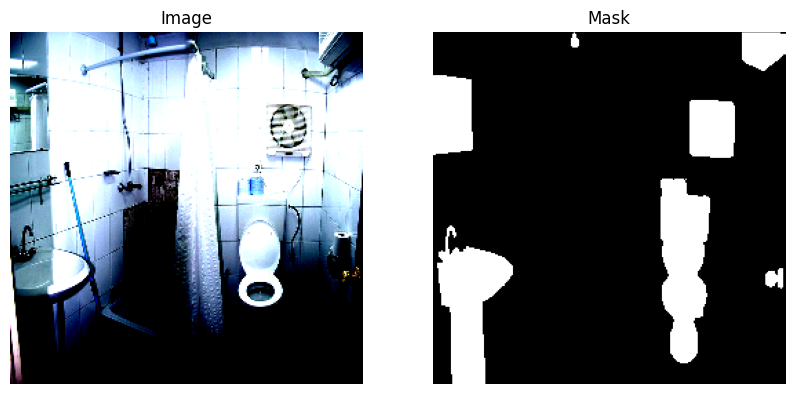

In [26]:
import matplotlib.pyplot as plt

def visualize_sample(dataset, idx=0):
    image, mask = dataset[idx]
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC for plotting
    mask = mask.squeeze().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.show()

# Try a few random ones
visualize_sample(lvis_dataset, idx=5)


In [27]:
generator.to(device)
discriminator.to(device)


MFPDiscriminator(
  (model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [28]:
!pip install -q albumentations


In [29]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the transform pipeline
def get_train_transform():
    return A.Compose([
        A.Resize(256, 256),  # or whatever your model input size is
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet means
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])


In [30]:
train_transform = get_train_transform()

lvis_dataset = LVISInteractiveDataset(
    image_dir='/kaggle/input/lvis-v1/lvis_v1_val/val2017',  # adjust if using train2017 later
    annotation_path='/kaggle/input/lvis-v1/lvis_v1_val/lvis_v1_val.json',
    transform=train_transform
)


loading annotations into memory...
Done (t=4.29s)
creating index...
index created!


In [31]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    lvis_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


STEP 7: Training Loop for GAN + Segmentation

In [32]:
for name, param in generator.named_parameters():
    if torch.isnan(param).any():
        print(f"NaN in param: {name}")
    if torch.isinf(param).any():
        print(f"Inf in param: {name}")


In [33]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

generator.apply(weights_init)


MFPResNetUNet(
  (in_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [34]:
generator.cpu()
discriminator.cpu()

x = torch.randn(1, 3, 256, 256)  # assuming input image shape
with torch.no_grad():
    out = generator(x)
    print("Generator output shape:", out.shape)

    d_out = discriminator(x, out)
    print("Discriminator output shape:", d_out.shape)


Generator output shape: torch.Size([1, 1, 256, 256])
Discriminator output shape: torch.Size([1, 1, 13, 13])


In [35]:
from torch import nn
import torchvision.models as models

# Dummy ResNet-based UNet model (simplified)
class DummyUNet(nn.Module):
    def __init__(self):
        super(DummyUNet, self).__init__()
        self.backbone = models.resnet34(weights=None)
        self.conv = nn.Conv2d(512, 1, kernel_size=1)
    
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.conv(x)
        return self.sigmoid(x)

# Instantiate and test move to CUDA
dummy_gen = DummyUNet()
dummy_gen.to(device)




DummyUNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [36]:
generator = generator.float()
discriminator = discriminator.float()


In [37]:
generator.to(device)
discriminator.to(device)


MFPDiscriminator(
  (model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)


MFPDiscriminator(
  (model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [39]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        bce = self.bce(inputs, targets)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        return bce + dice

def visualize_debug(images, masks, preds, idx=0):
    image = images[idx].permute(1, 2, 0).cpu().numpy()
    mask = masks[idx][0].cpu().numpy()
    pred = preds[idx][0].cpu().numpy()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(image); plt.title("Input")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title("GT")
    plt.subplot(1, 3, 3); plt.imshow(pred, cmap='gray'); plt.title("Pred")
    plt.tight_layout(); plt.savefig("outputs/debug.png"); plt.show()


In [40]:
# Create BCE and Dice loss objects
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceBCELoss()

# Final segmentation loss combining both
def combined_seg_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)


In [41]:
generator.to(device)
discriminator.to(device)


MFPDiscriminator(
  (model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [42]:
seg_loss_fn = nn.BCELoss().to(device)
adv_loss_fn = nn.BCELoss().to(device)


In [43]:
import torch.nn.functional as F

def adv_loss_fn(pred, is_real=True):
    if is_real:
        return F.softplus(-pred).mean()  # log(1 + exp(-x))
    else:
        return F.softplus(pred).mean()   # log(1 + exp(x))


In [44]:
from tqdm import tqdm
import torch
import torch.nn as nn

def train_gan_segmentation(generator, discriminator, dataloader,
                           gen_optimizer, disc_optimizer,
                           seg_loss_fn, adv_loss_fn,
                           device, epochs=10, adv_weight=0.01):

    generator.to(device)
    discriminator.to(device)
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        total_gen_loss = 0
        total_disc_loss = 0

        loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)

        for batch_idx, (images, real_masks) in enumerate(loop):
            images = images.to(device)
            real_masks = real_masks.to(device)
            if real_masks.ndim == 3:
                real_masks = real_masks.unsqueeze(1)
            real_masks = real_masks.float()

            fake_masks = generator(images)

            # Discriminator Step
            disc_optimizer.zero_grad()
            real_preds = discriminator(images, real_masks)
            fake_preds = discriminator(images, fake_masks.detach())

            real_labels = torch.ones_like(real_preds)
            fake_labels = torch.zeros_like(fake_preds)

            real_loss = adv_loss_fn(real_preds, real_labels)
            fake_loss = adv_loss_fn(fake_preds, fake_labels)
            disc_loss = (real_loss + fake_loss) / 2
            disc_loss.backward()
            disc_optimizer.step()

            # Generator Step
            gen_optimizer.zero_grad()
            gen_adv_preds = discriminator(images, fake_masks)
            adv_loss = adv_loss_fn(gen_adv_preds, real_labels)
            seg_loss = seg_loss_fn(fake_masks, real_masks)
            gen_loss = seg_loss + adv_weight * adv_loss
            gen_loss.backward()
            gen_optimizer.step()

            total_gen_loss += gen_loss.item()
            total_disc_loss += disc_loss.item()

            loop.set_postfix({
                "Seg": f"{seg_loss.item():.4f}",
                "Adv": f"{adv_loss.item():.4f}",
                "Gen": f"{gen_loss.item():.4f}",
                "Disc": f"{disc_loss.item():.4f}"
            })

        print(f"[Epoch {epoch+1}] Gen Loss: {total_gen_loss:.4f}, Disc Loss: {total_disc_loss:.4f}")

        # Visualize 1 sample
        with torch.no_grad():
            preds = torch.sigmoid(fake_masks)
            binary = (preds > 0.5).float()
            visualize_debug(images.cpu(), real_masks.cpu(), binary, idx=min(2, images.size(0) - 1))

    
       

loading annotations into memory...
Done (t=7.32s)
creating index...
index created!


[Epoch 1] Gen Loss: 1634.9628, Disc Loss: 45.5742


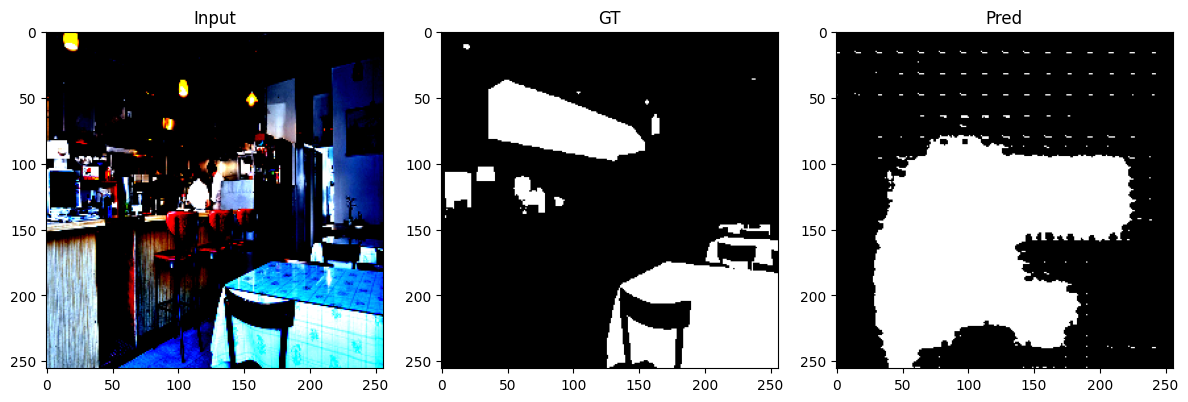

[Epoch 2] Gen Loss: 1565.2071, Disc Loss: 1.3639


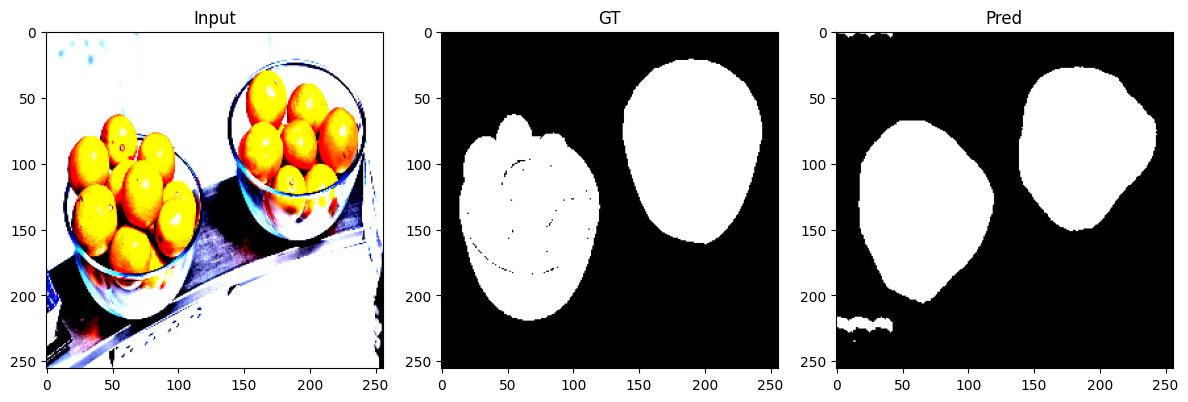

[Epoch 3] Gen Loss: 1545.9020, Disc Loss: 7.6362


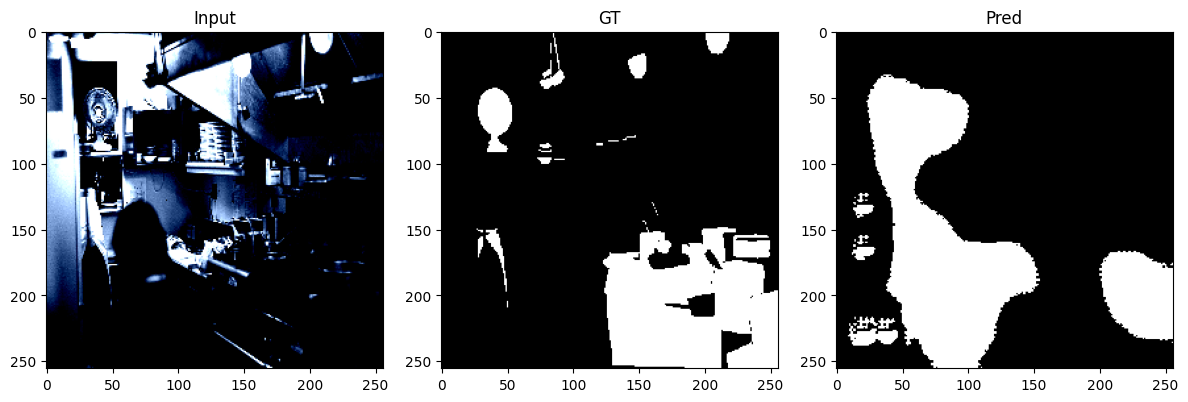

[Epoch 4] Gen Loss: 1520.7107, Disc Loss: 0.1125


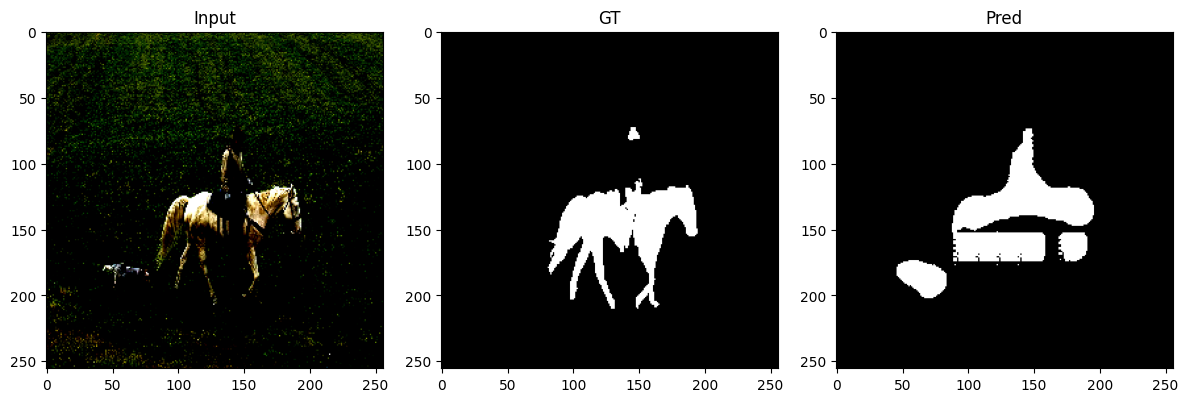

[Epoch 5] Gen Loss: 1513.4862, Disc Loss: 4.0956


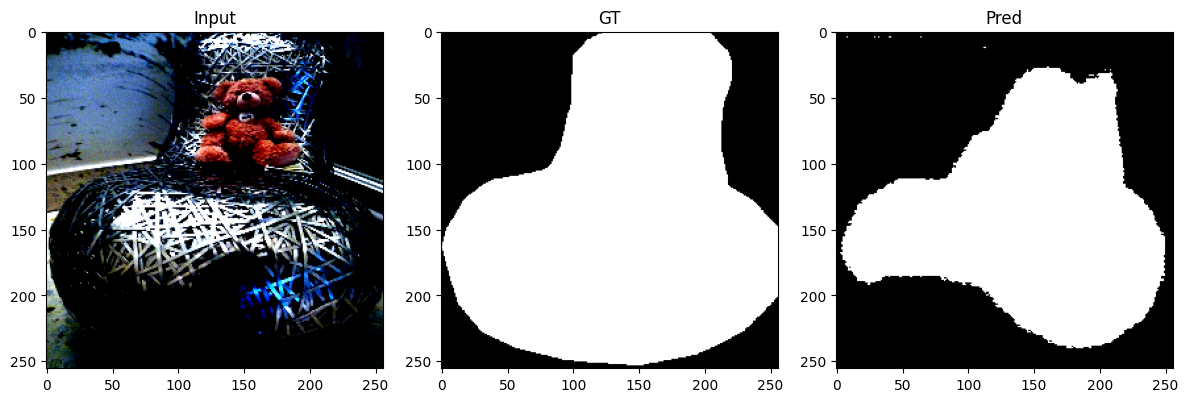

[Epoch 6] Gen Loss: 1497.4191, Disc Loss: 0.0356


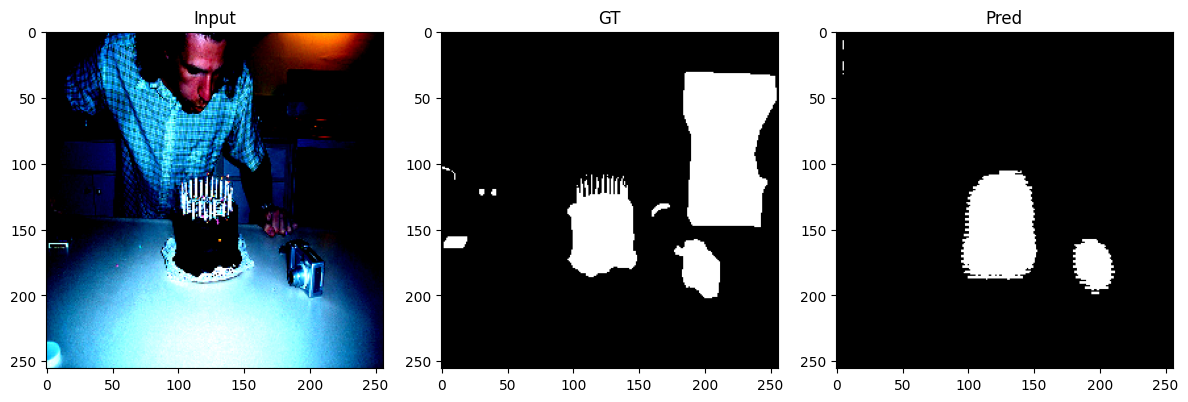

[Epoch 7] Gen Loss: 1498.6839, Disc Loss: 0.0141


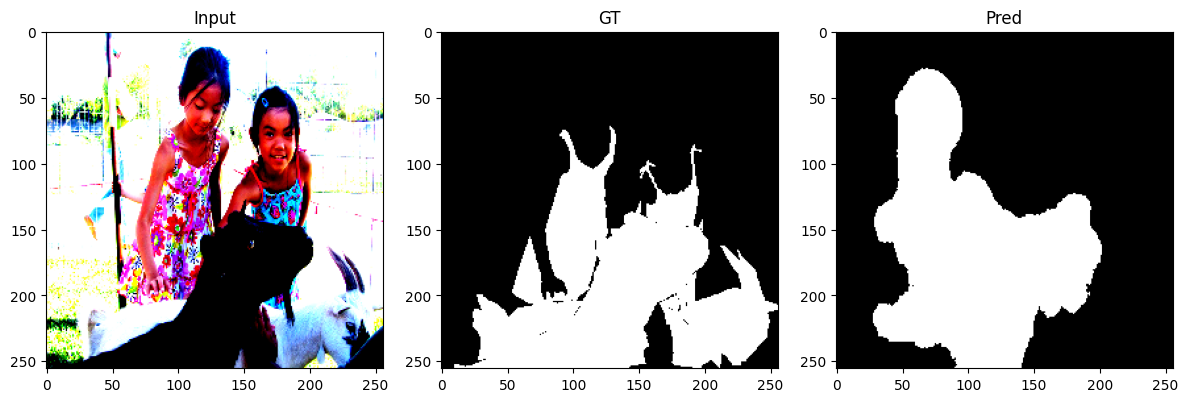

[Epoch 8] Gen Loss: 1465.3760, Disc Loss: 0.0089


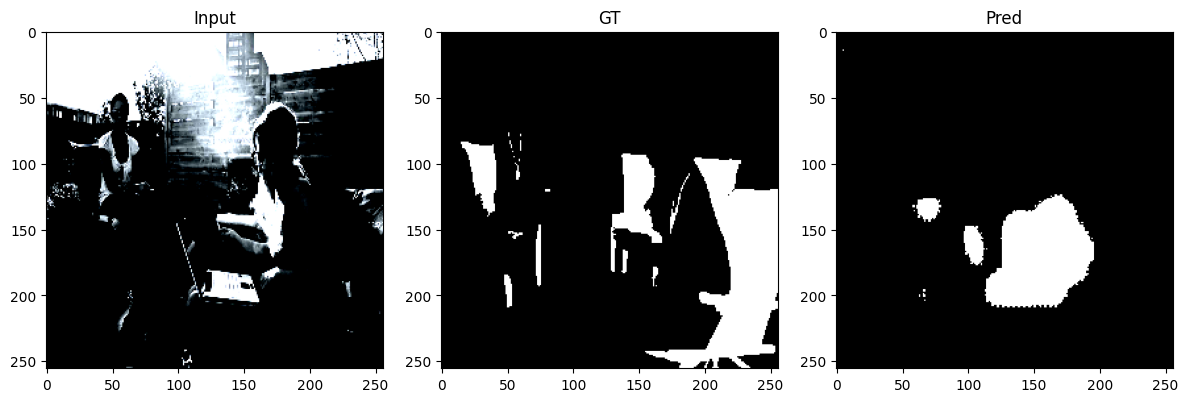

[Epoch 9] Gen Loss: 1451.8015, Disc Loss: 0.0081


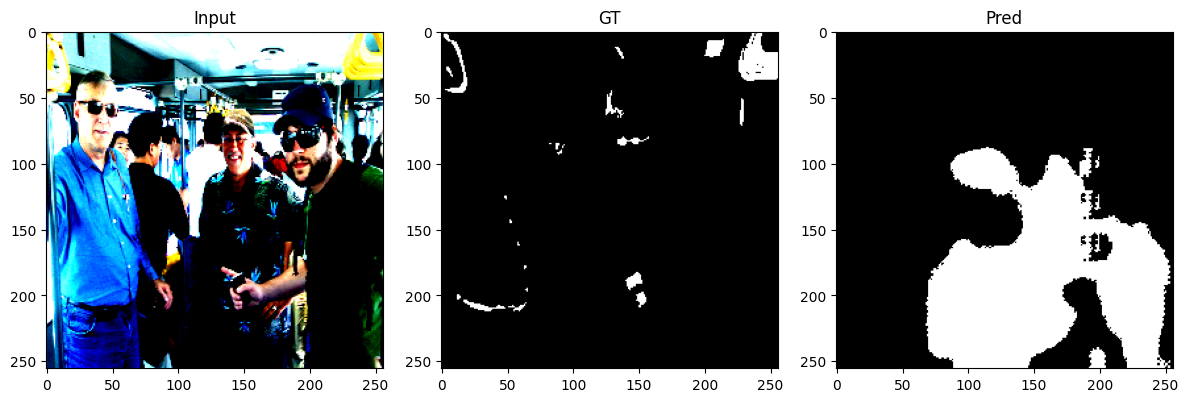

[Epoch 10] Gen Loss: 1457.7421, Disc Loss: 0.0025


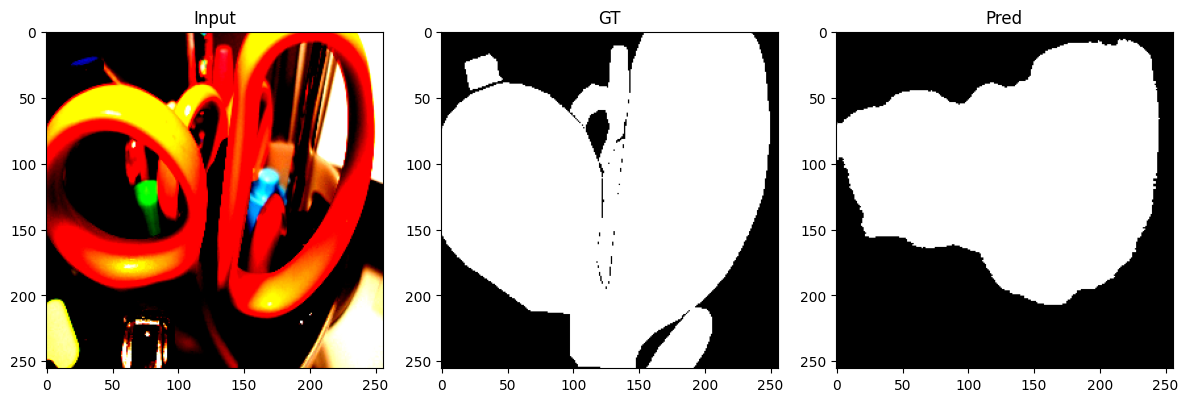

[Epoch 11] Gen Loss: 1370.1703, Disc Loss: 12.0162


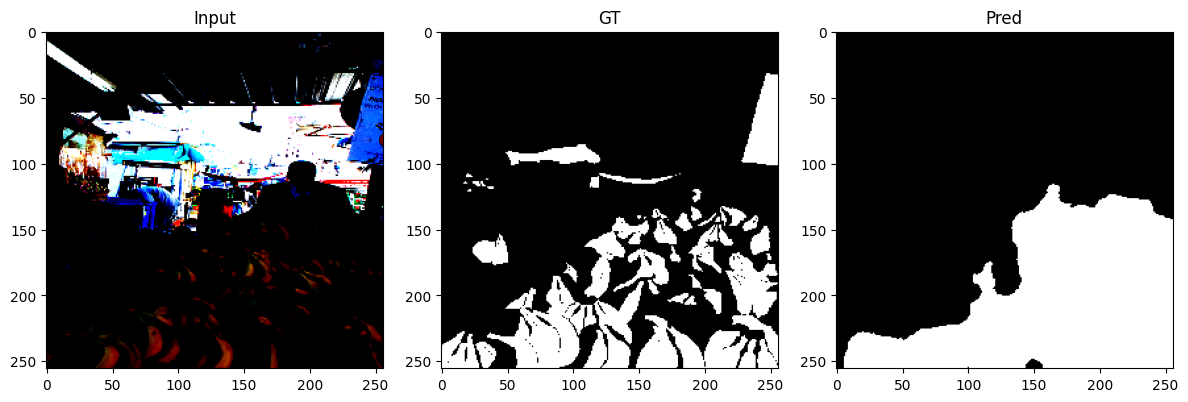

[Epoch 12] Gen Loss: 1375.3379, Disc Loss: 0.0650


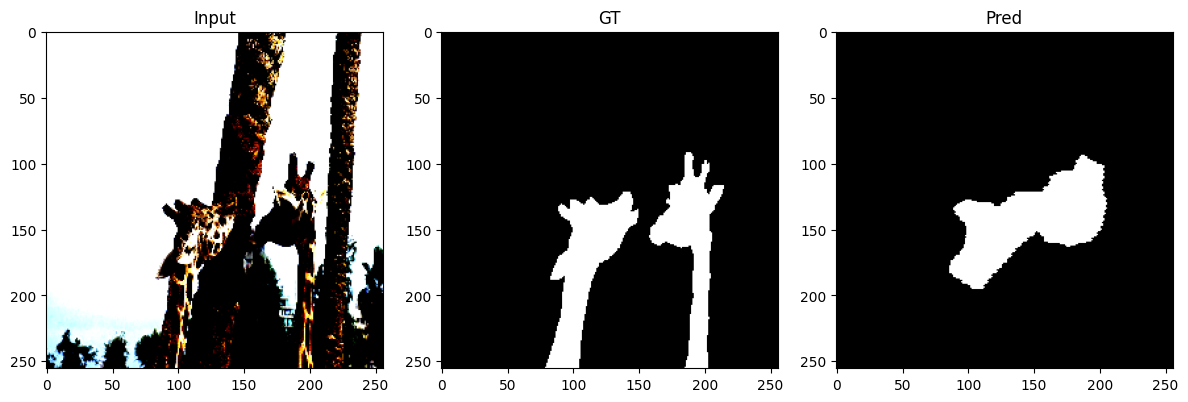

[Epoch 13] Gen Loss: 1370.4756, Disc Loss: 0.0386


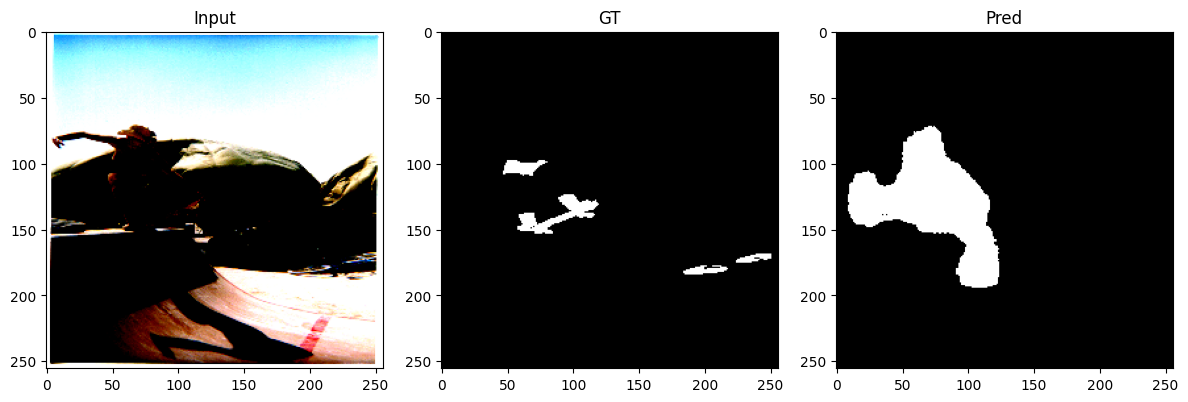

[Epoch 14] Gen Loss: 1380.9560, Disc Loss: 0.0170


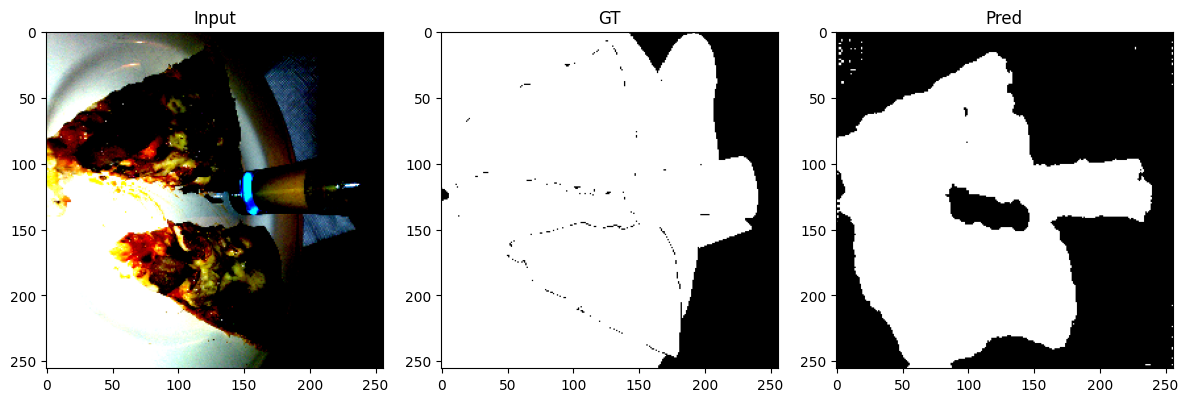

[Epoch 15] Gen Loss: 1371.1433, Disc Loss: 0.0069


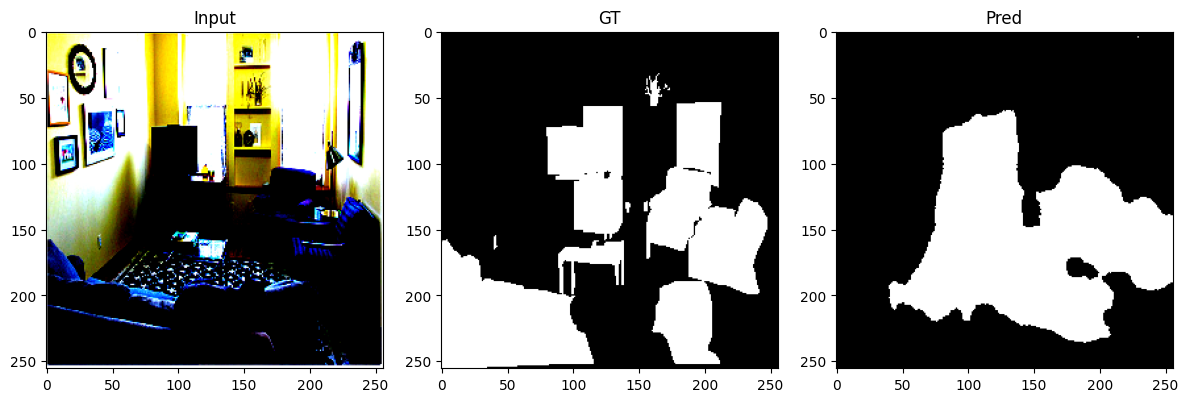

[Epoch 16] Gen Loss: 1380.9863, Disc Loss: 0.0026


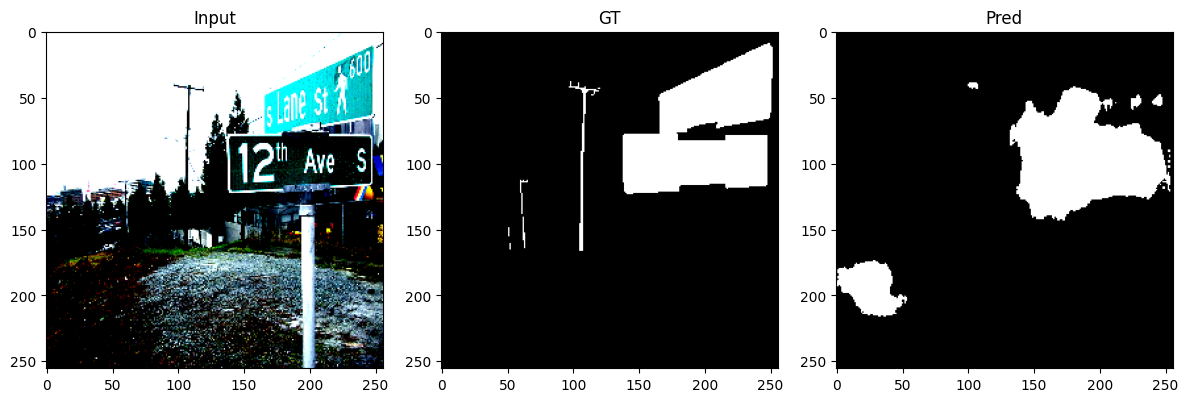

[Epoch 17] Gen Loss: 1347.2596, Disc Loss: 4.6496


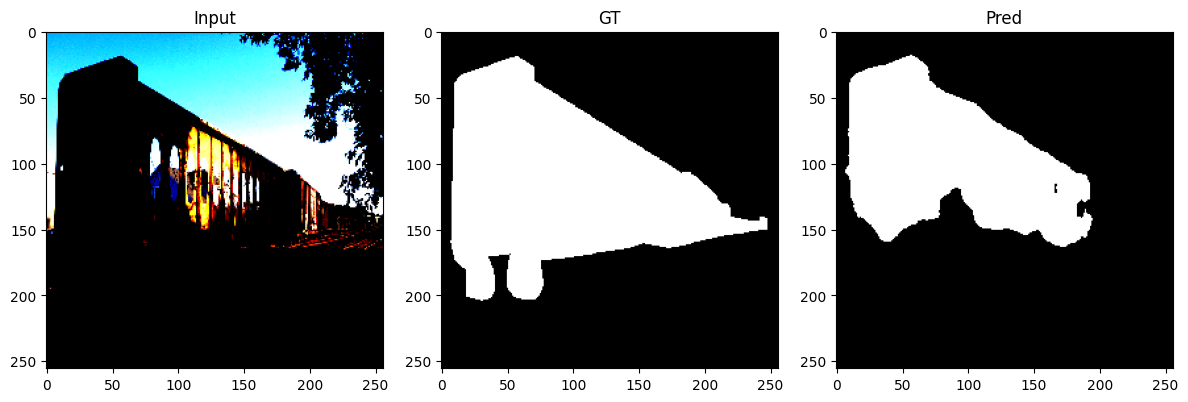

[Epoch 18] Gen Loss: 1320.5296, Disc Loss: 0.0621


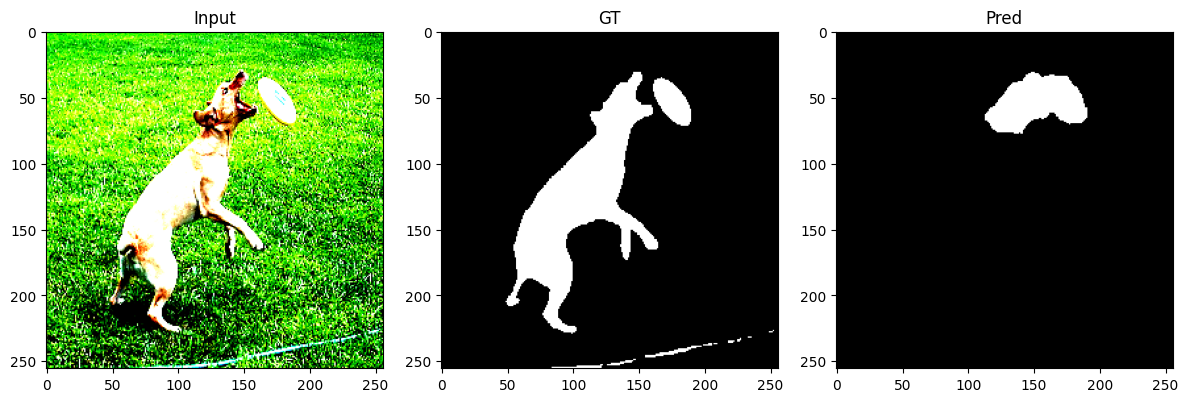

[Epoch 19] Gen Loss: 1319.2786, Disc Loss: 0.0134


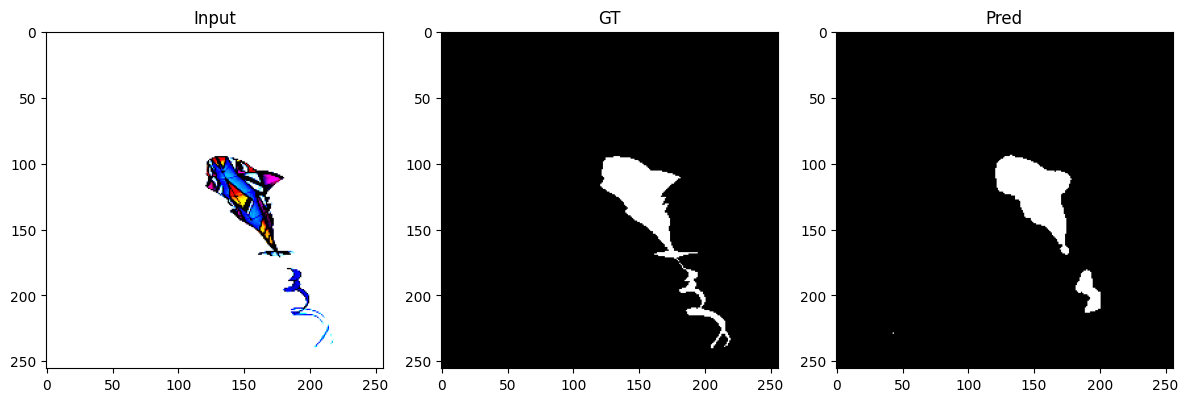

[Epoch 20] Gen Loss: 1329.0391, Disc Loss: 0.0070


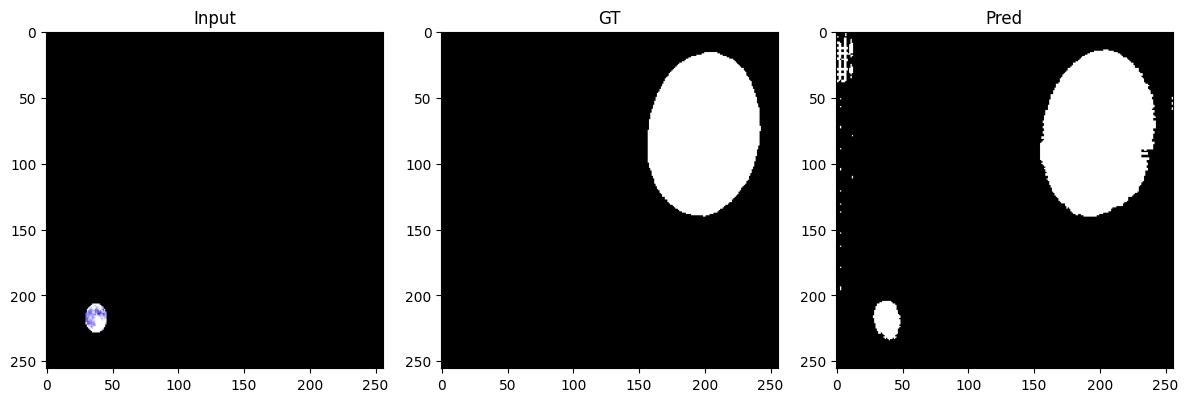

[Epoch 21] Gen Loss: 1304.2206, Disc Loss: 0.0067


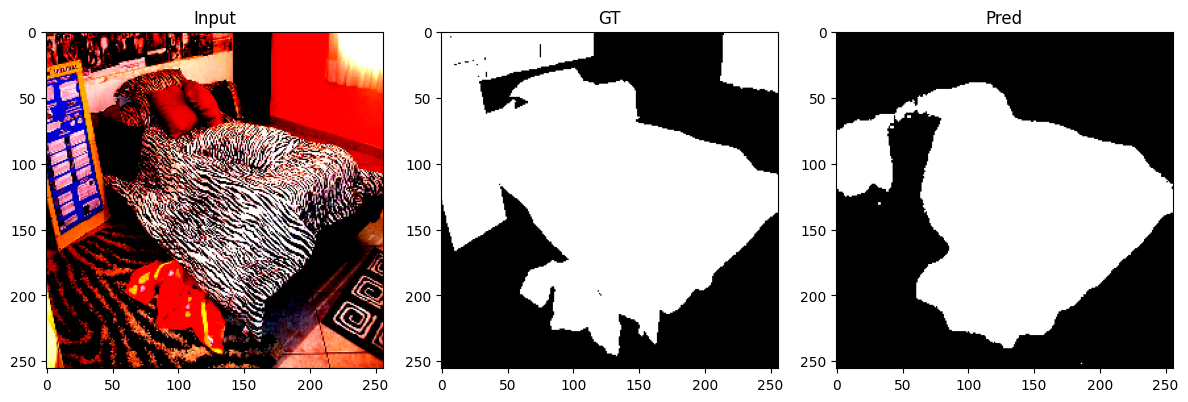

[Epoch 22] Gen Loss: 1304.4195, Disc Loss: 0.0031


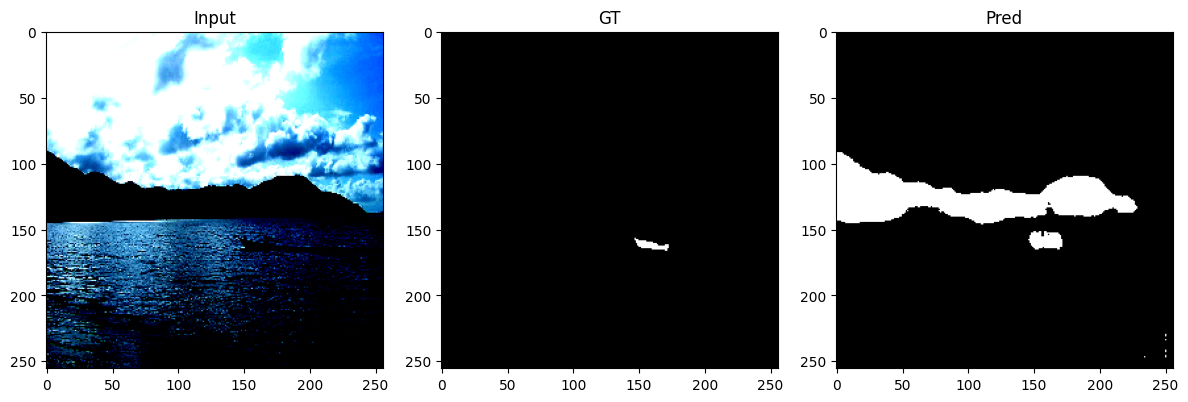

[Epoch 23] Gen Loss: 1321.5003, Disc Loss: 0.0011


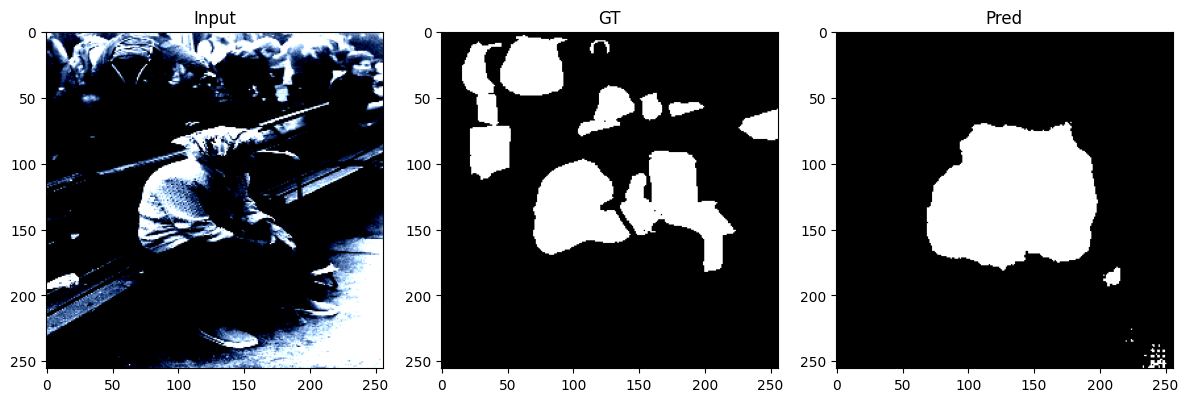

[Epoch 24] Gen Loss: 1310.9378, Disc Loss: 0.0007


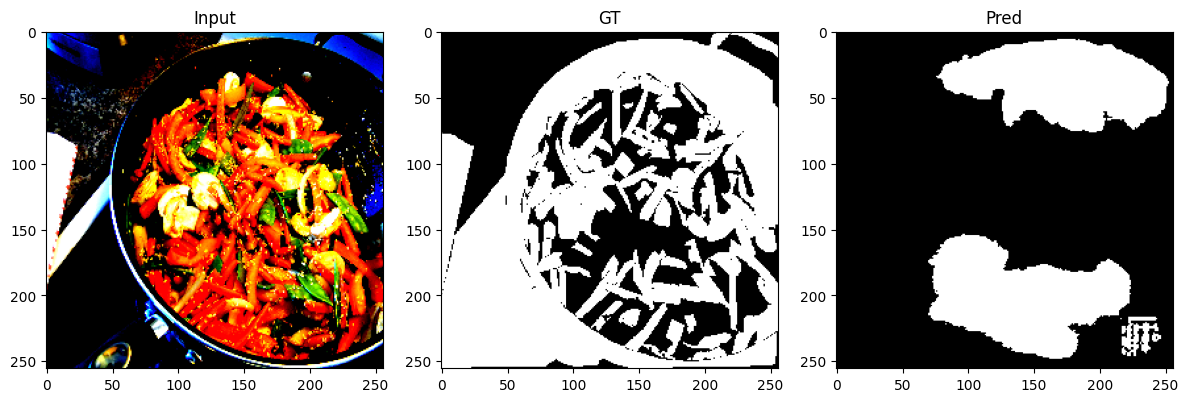

[Epoch 25] Gen Loss: 1321.8042, Disc Loss: 0.0002


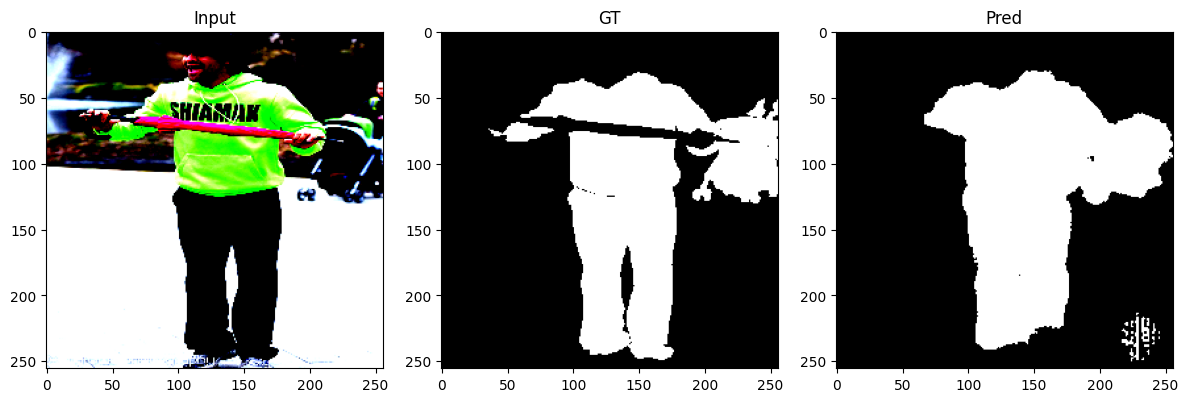

[Epoch 26] Gen Loss: 1311.9658, Disc Loss: 0.0001


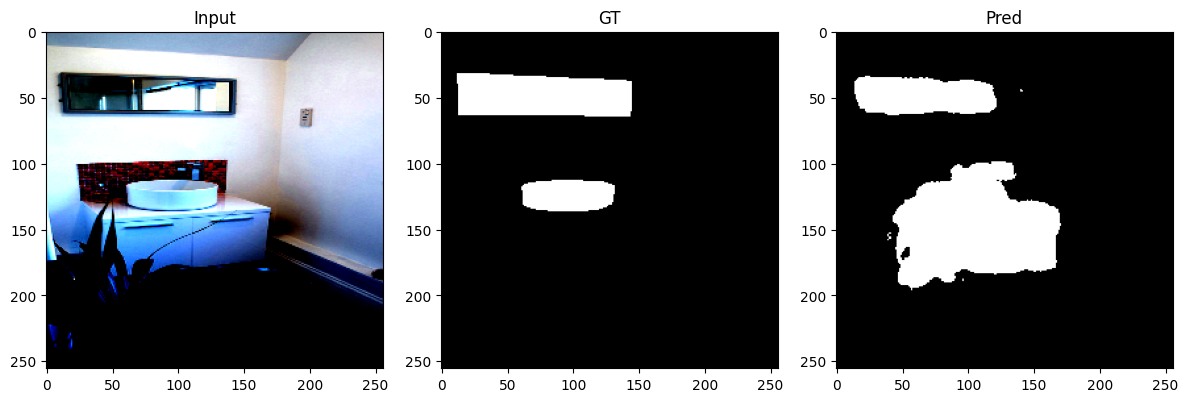

[Epoch 27] Gen Loss: 1308.2008, Disc Loss: 0.0000


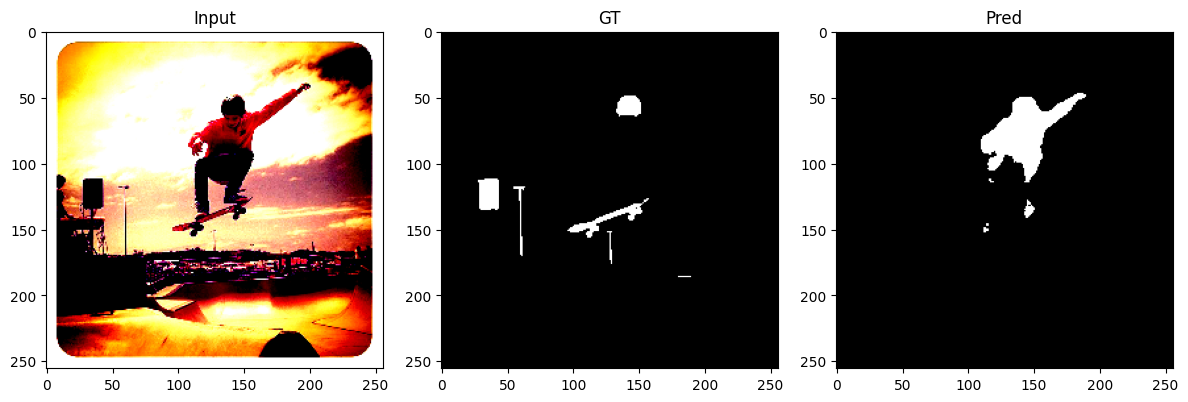

[Epoch 28] Gen Loss: 1312.4002, Disc Loss: 0.0000


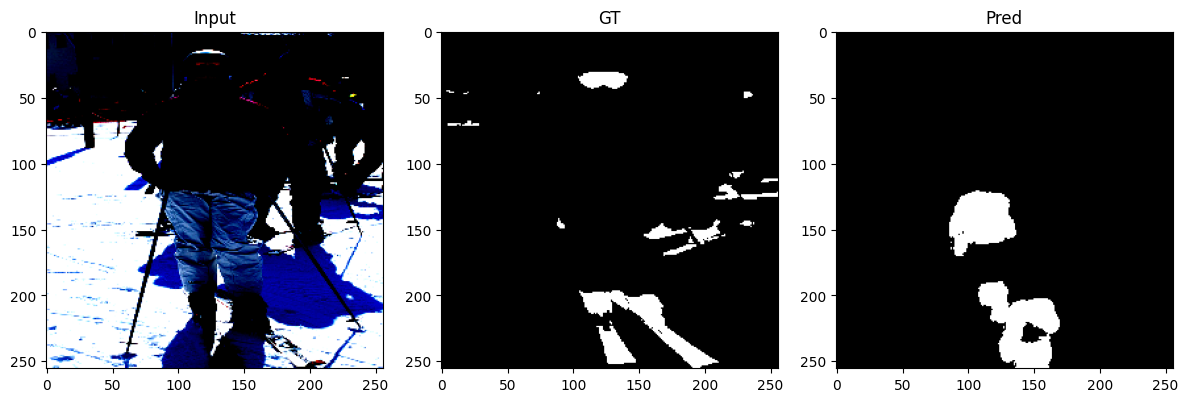

[Epoch 29] Gen Loss: 1318.2149, Disc Loss: 0.0000


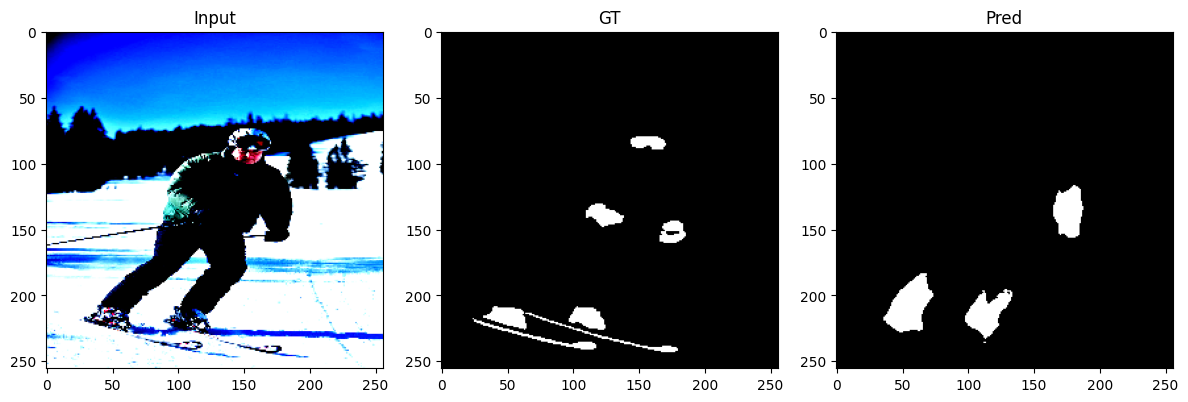

[Epoch 30] Gen Loss: 1327.9731, Disc Loss: 0.0000


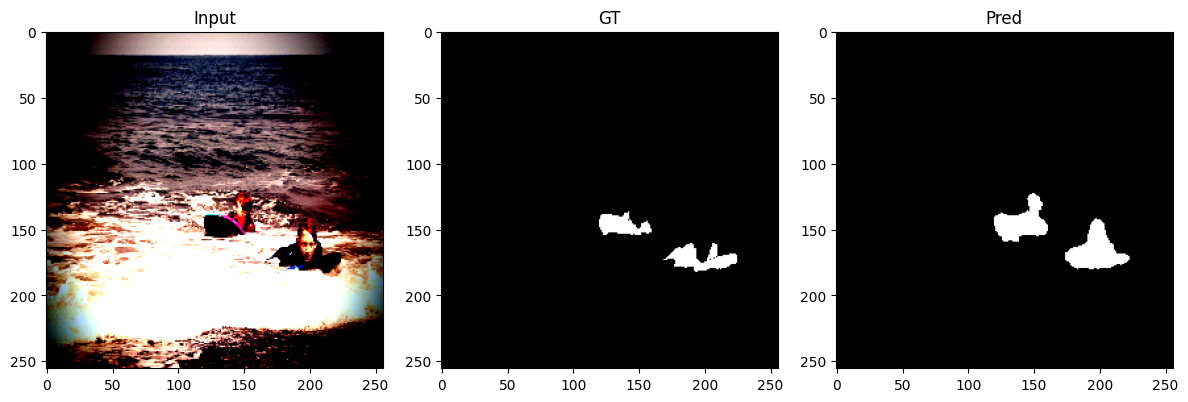

In [45]:
# Paths
image_dir = "/kaggle/input/lvis-v1/lvis_v1_val/val2017"
annotation_path = "/kaggle/input/lvis-v1/lvis_v1_val/lvis_v1_val.json"

# Dataset and DataLoader
dataset = LVISInteractiveDataset(image_dir, annotation_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Models
generator = MFPResNetUNet()
discriminator = MFPDiscriminator()

# Optimizers
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Loss functions
seg_loss_fn = DiceBCELoss()
adv_loss_fn = nn.BCEWithLogitsLoss()

# Train
train_gan_segmentation(generator, discriminator, train_loader,
                       gen_optimizer, disc_optimizer,
                       seg_loss_fn, adv_loss_fn,
                       device, epochs=30)


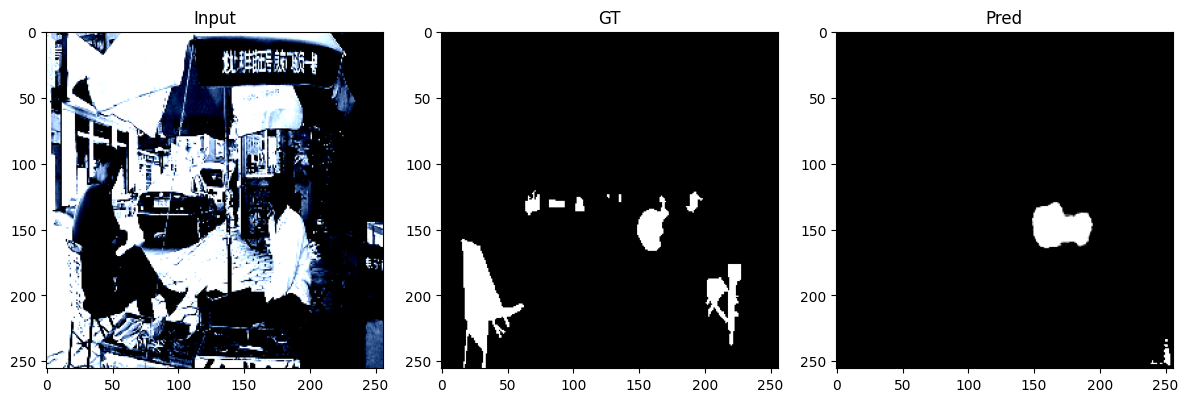

In [46]:
# Set the model to eval mode
generator.eval()

# Get a batch from the dataloader
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = generator(images)
        preds = torch.sigmoid(logits)  # Convert logits to probability

        # Move to CPU for plotting
        images = images.cpu()
        masks = masks.cpu()
        preds = preds.cpu()
        
        # Visualize
        visualize_debug(images, masks, preds, idx=2)
        break  # only show one batch


In [47]:
from tqdm import tqdm


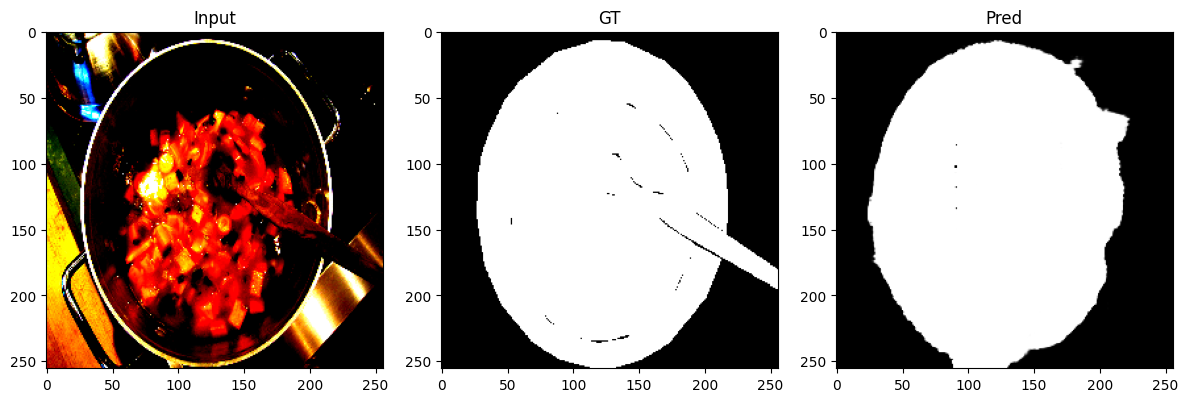

In [48]:
# Set the model to eval mode
generator.eval()

# Get a batch from the dataloader
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = generator(images)
        preds = torch.sigmoid(logits)  # Convert logits to probability

        # Move to CPU for plotting
        images = images.cpu()
        masks = masks.cpu()
        preds = preds.cpu()
        
        # Visualize
        visualize_debug(images, masks, preds, idx=2)
        break  # only show one batch


In [49]:
## import matplotlib.pyplot as plt

def visualize_output(images, real_masks, fake_masks, idx=0):
    image = images[idx].permute(1, 2, 0).detach().cpu().numpy()
    real_mask = real_masks[idx][0].detach().cpu().numpy()
    fake_mask = torch.sigmoid(fake_masks[idx][0]).detach().cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(real_mask, cmap="gray")
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(fake_mask, cmap="gray")
    plt.title("Predicted Mask")

    plt.show()




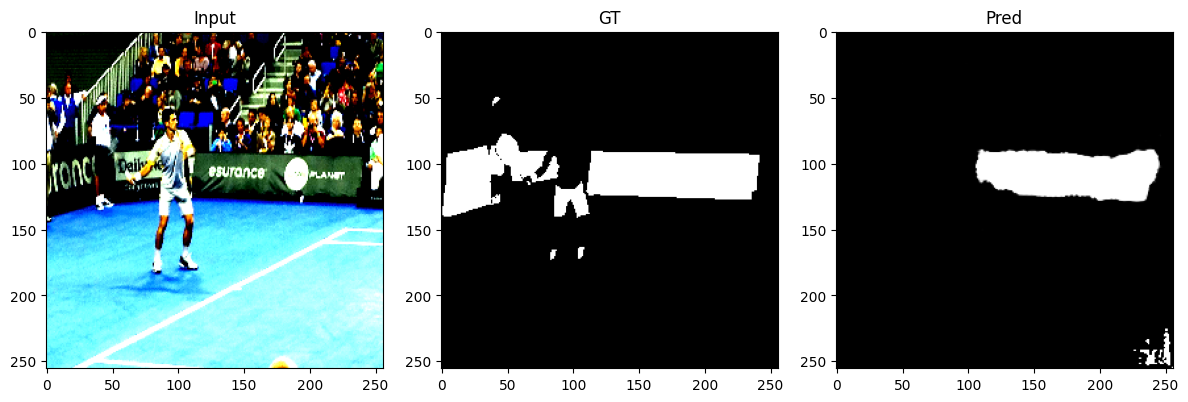

In [50]:
# Set the model to eval mode
generator.eval()

# Get a batch from the dataloader
with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = generator(images)
        preds = torch.sigmoid(logits)  # Convert logits to probability

        # Move to CPU for plotting
        images = images.cpu()
        masks = masks.cpu()
        preds = preds.cpu()
        
        # Visualize
        visualize_debug(images, masks, preds, idx=2)
        break  # only show one batch


In [51]:
import matplotlib.pyplot as plt

# Example image saving function
def save_visualization(input_img, ground_truth, prediction, idx):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    axs[0].imshow(input_img.permute(1, 2, 0).numpy())  # assuming shape (3, H, W)
    axs[0].set_title("Input Image")

    axs[1].imshow(ground_truth.squeeze().cpu().numpy(), cmap='gray')
    axs[1].set_title("Ground Truth")

    axs[2].imshow(prediction.squeeze().cpu().numpy(), cmap='gray')
    axs[2].set_title("Predicted Mask")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"outputs/images/vis_{idx}.png")  #  saved output
    plt.close()

In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score,
    jaccard_score,
    precision_score,
    recall_score,
    confusion_matrix
)


In [53]:
from sklearn.metrics import accuracy_score

In [54]:
def evaluate_one_batch(generator, dataloader, device, threshold=0.5, save_confmat_path=None):
    generator.eval()
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            logits = generator(images)
            preds = torch.sigmoid(logits)

            preds_bin = (preds > threshold).float().cpu()
            masks_cpu = masks.cpu()

            for pred, mask in zip(preds_bin, masks_cpu):
                pred_np = pred.squeeze().numpy().astype(int).flatten()
                mask_np = mask.squeeze().numpy().astype(int).flatten()
                y_pred_all.extend(pred_np)
                y_true_all.extend(mask_np)

            break  # Only process the first batch

    # Compute metrics
    dice = f1_score(y_true_all, y_pred_all, zero_division=1)
    iou = jaccard_score(y_true_all, y_pred_all, zero_division=1)
    precision = precision_score(y_true_all, y_pred_all, zero_division=1)
    recall = recall_score(y_true_all, y_pred_all, zero_division=1)
    accuracy = accuracy_score(y_true_all, y_pred_all)

    print("\n Evaluation Metrices:")
    print(f"Dice Score   : {dice:.4f}")
    print(f"IoU Score    : {iou:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Accuracy     : {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Background", "Foreground"],
                yticklabels=["Background", "Foreground"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (One Batch)")

    if save_confmat_path:
        plt.savefig(save_confmat_path)
        plt.close()
    else:
        plt.show()


In [55]:
evaluate_one_batch(generator, train_loader, device, threshold=0.5,
                   save_confmat_path="outputs/confusion_matrix_batch.png")



 Evaluation Metrices:
Dice Score   : 0.7352
IoU Score    : 0.5813
Precision    : 0.7430
Recall       : 0.7276
Accuracy     : 0.9105


In [56]:
from sklearn.metrics import (
    f1_score, jaccard_score, precision_score, recall_score,
    confusion_matrix, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def evaluate_five_batches(generator, dataloader, device, threshold=0.5, save_confmat_path=None):
    generator.eval()
    y_true_all = []
    y_pred_all = []
    batch_count = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            logits = generator(images)
            preds = torch.sigmoid(logits)

            preds_bin = (preds > threshold).float().cpu()
            masks_cpu = masks.cpu()

            for pred, mask in zip(preds_bin, masks_cpu):
                pred_np = pred.squeeze().numpy().astype(int).flatten()
                mask_np = mask.squeeze().numpy().astype(int).flatten()
                y_pred_all.extend(pred_np)
                y_true_all.extend(mask_np)

            batch_count += 1
            if batch_count >= 5:
                break

    # Compute metrics
    dice = f1_score(y_true_all, y_pred_all, zero_division=1)
    iou = jaccard_score(y_true_all, y_pred_all, zero_division=1)
    precision = precision_score(y_true_all, y_pred_all, zero_division=1)
    recall = recall_score(y_true_all, y_pred_all, zero_division=1)
    accuracy = accuracy_score(y_true_all, y_pred_all)

    print("\nEvaluation on First 5 Batches:")
    print(f"Dice Score   : {dice:.4f}")
    print(f"IoU Score    : {iou:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Accuracy     : {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Background", "Foreground"],
                yticklabels=["Background", "Foreground"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (First 5 Batches)")

    if save_confmat_path:
        plt.savefig(save_confmat_path)
        plt.close()
    else:
        plt.show()


In [57]:
evaluate_five_batches(generator, train_loader, device, 
                      threshold=0.5, 
                      save_confmat_path="outputs/confmat_5batches.png")



Evaluation on First 5 Batches:
Dice Score   : 0.8667
IoU Score    : 0.7647
Precision    : 0.8824
Recall       : 0.8515
Accuracy     : 0.9313
